In [140]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector, RFE, SelectFromModel, SelectKBest, chi2, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [141]:
data = pd.read_csv(r'src\rawDataset.csv')

In [142]:
data.drop(columns=['RowNumber','Surname','CustomerId'], inplace= True)

In [143]:
numeric_columns = ["CreditScore", "Tenure", "Balance", "EstimatedSalary", "Point Earned"]

In [144]:
bins = [0, 30, 40, 50, 60, 100]  
labels = ['<30', '30-40', '40-50', '50-60', '>60']

data['Age'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)


In [145]:
categorical_columns = ['Age', 'Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'Satisfaction Score', 'Card Type']

In [146]:
encoder = OneHotEncoder(sparse_output=False, drop='first', dtype=int)

catcols = ['Gender','Geography', 'Card Type']
encData = encoder.fit_transform(data[catcols])
encDF = pd.DataFrame(encData, columns=encoder.get_feature_names_out(catcols))
data2 = pd.concat([data.drop(columns= catcols),encDF],axis=1)

data2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,Gender_Male,Geography_Germany,Geography_Spain,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,40-50,2,0.00,1,1,1,101348.88,1,1,2,464,0,0,0,0,0,0
1,608,40-50,1,83807.86,1,0,1,112542.58,0,1,3,456,0,0,1,0,0,0
2,502,40-50,8,159660.80,3,1,0,113931.57,1,1,3,377,0,0,0,0,0,0
3,699,30-40,1,0.00,2,0,0,93826.63,0,0,5,350,0,0,0,1,0,0
4,850,40-50,2,125510.82,1,1,1,79084.10,0,0,5,425,0,0,1,1,0,0


In [147]:
def winsorize_outliers(data, column, multiplier):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    low_bound = q1 - multiplier * iqr
    high_bound = q3 + multiplier * iqr

    data[column] = np.where(data[column] < low_bound, low_bound, data[column])
    data[column] = np.where(data[column] > high_bound, high_bound, data[column])

In [148]:
data['Tenure'] = data['Tenure'].astype(int)
data['NumOfProducts'] = data['NumOfProducts'].astype(int)
data['HasCrCard'] = data['HasCrCard'].astype(int)
data['IsActiveMember'] = data['IsActiveMember'].astype(int)
data['Exited'] = data['Exited'].astype(int)
data['Complain'] = data['Complain'].astype(int)
data['Satisfaction Score'] = data['Satisfaction Score'].astype(int)

In [149]:
scaler = StandardScaler()
data[numeric_columns]= scaler.fit_transform(data[numeric_columns])

In [150]:
data['Balance_to_Salary'] = data['Balance'] / (data['EstimatedSalary'] + 1)

# ahora mi parte

In [151]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import (adjusted_rand_score, mutual_info_score, homogeneity_score,
                             completeness_score, v_measure_score, silhouette_score,
                             calinski_harabasz_score, davies_bouldin_score)


In [153]:
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Point Earned', 'Balance_to_Salary']
categorical_features = ['Geography', 'Gender', 'Card Type']

In [154]:
print(data[numerical_features].describe())

        CreditScore        Tenure       Balance  NumOfProducts  \
count  1.000000e+04  1.000000e+04  1.000000e+04   10000.000000   
mean  -4.824585e-16 -1.078249e-16 -6.252776e-17       1.530200   
std    1.000050e+00  1.000050e+00  1.000050e+00       0.581654   
min   -3.109504e+00 -1.733315e+00 -1.225848e+00       1.000000   
25%   -6.883586e-01 -6.959818e-01 -1.225848e+00       1.000000   
50%    1.522218e-02 -4.425957e-03  3.319639e-01       1.000000   
75%    6.981094e-01  6.871299e-01  8.199205e-01       2.000000   
max    2.063884e+00  1.724464e+00  2.795323e+00       4.000000   

       EstimatedSalary  Point Earned  Balance_to_Salary  
count     1.000000e+04  1.000000e+04       10000.000000  
mean     -2.877698e-17  1.696421e-16          -5.866980  
std       1.000050e+00  1.000050e+00         373.829180  
min      -1.740268e+00 -2.157972e+00      -27423.703728  
25%      -8.535935e-01 -8.698686e-01          -0.876574  
50%       1.802807e-03 -6.706548e-03           0.182933  

In [155]:
data2 = data.drop(columns=["Exited"])

In [156]:
data_C = data2[numeric_columns + ['Balance_to_Salary']]


In [157]:
y = data["Exited"]

In [158]:
inertia = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_C)
    inertia.append(kmeans.inertia_)

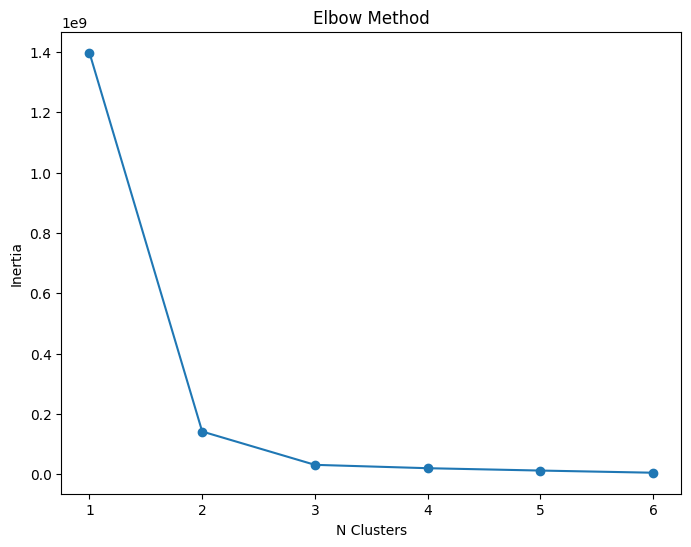

In [159]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("N Clusters")
plt.ylabel("Inertia")
plt.show()

In [160]:
cluster_num = 2

In [161]:
res = {}

In [162]:
def evaluate_clustering(true_labels, pred_labels, algorithm_name, data):
    res[algorithm_name] = {
      'Silhouette Score': silhouette_score(data, pred_labels),
        'Calinski-Harabasz Index': calinski_harabasz_score(data, pred_labels),
        'Davies-Bouldin Index': davies_bouldin_score(data, pred_labels),
    }

partitioning

In [163]:
kmeans = KMeans(n_clusters=cluster_num)
kmeans_labels = kmeans.fit_predict(data_C)

In [164]:
evaluate_clustering(y, kmeans_labels, 'KMeans', data_C)

In [165]:
print('KMeans results:')
for metric, score in res['KMeans'].items():
    print(f"{metric}: {score}")

KMeans results:
Silhouette Score: 0.9994655144147532
Calinski-Harabasz Index: 88649.83922775989
Davies-Bouldin Index: 0.09455651748958586


hierarchical (does not compute cluster centers)

In [166]:
agglo = AgglomerativeClustering(n_clusters=cluster_num)
data['Cluster'] = agglo.fit_predict(data_C)

BIRCH

In [167]:
birch = Birch(n_clusters=cluster_num)
birch_labels = birch.fit_predict(data_C)

In [168]:
evaluate_clustering(y, birch_labels, 'BIRCH', data_C)

In [169]:
print('BIRCH results:')
for metric, score in res['BIRCH'].items():
    print(f"{metric}: {score}")

BIRCH results:
Silhouette Score: 0.9994655144147532
Calinski-Harabasz Index: 88649.83922775989
Davies-Bouldin Index: 0.09455651748958586


density based

In [170]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)  # Adjust parameters as needed
optc_labels = optics.fit_predict(data_C)

In [171]:
evaluate_clustering(y, optc_labels, 'OPTICS', data_C)

In [172]:
print('OPTICS results:')
for metric, score in res['OPTICS'].items():
    print(f"{metric}: {score}")

OPTICS results:
Silhouette Score: 0.9749756427264294
Calinski-Harabasz Index: 258.2249031118014
Davies-Bouldin Index: 2.05304685205601


In [173]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=cluster_num)
dbscan_labels = dbscan.fit_predict(data_C)

In [174]:
evaluate_clustering(y, dbscan_labels, 'DBSCAN', data_C)

In [175]:
print('DBSCAN results:')
for metric, score in res['DBSCAN'].items():
    print(f"{metric}: {score}")

DBSCAN results:
Silhouette Score: -0.49718586853619884
Calinski-Harabasz Index: 0.0076305324421075925
Davies-Bouldin Index: 2.4809427775895827


gaussian

In [176]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=cluster_num)
gmm_labels = gmm.fit_predict(data_C)

In [177]:
evaluate_clustering(y, gmm_labels, 'GaussianMixture', data_C)

In [178]:
print('GaussianMixture results:')
for metric, score in res['GaussianMixture'].items():
    print(f"{metric}: {score}")

GaussianMixture results:
Silhouette Score: 0.9994655144147532
Calinski-Harabasz Index: 88649.83922775989
Davies-Bouldin Index: 0.09455651748958586


Conclussions